COMP2261 Artificial Intelligence 
==============

***Importing the modules and packages needed***


The project utilises a range of librarys, most importantly NumPy to allow for the development of the custom implementation model


In [2]:
import torch 
import os
import mmbra #library for data visualisations
import scipy.io as sio
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import time #needed for time measurement
np.random.seed(42) #for reproducibility

***Create code for custom model implementation***


Below is the manual implementation of the Random Forest classifier model. It is built on finding the most popular classification of running multiple recursive decision trees. 

In [3]:


class Node: #class for the nodes of the decision tree
    def __init__(self, feature=None, threshold=None, left=None, right=None,*,value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
        
    def is_leaf_node(self): #check if the node is a leaf node
        return self.value is not None


class DecisionTree: #class for the decision tree
    def __init__(self, min_samples_split=2, max_depth=100, n_features=None):   #hyperparameters for the tree
        self.min_samples_split=min_samples_split
        self.max_depth=max_depth
        self.n_features=n_features
        self.root=None

    def fit(self, X, y): #fit the tree to the data for training
        self.n_features = X.shape[1] if not self.n_features else min(X.shape[1],self.n_features)
        self.root = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_feats = X.shape
        n_labels = len(np.unique(y))

        if (depth>=self.max_depth or n_labels==1 or n_samples<self.min_samples_split): #stop criteria
            leaf_value = self._most_common_label(y) 
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_feats, self.n_features, replace=False)
        best_feature, best_thresh = self._best_split(X, y, feat_idxs)


        left_idxs, right_idxs = self._split(X[:, best_feature], best_thresh) #split the data between two child nodes
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth+1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth+1)
        return Node(best_feature, best_thresh, left, right)


    def _best_split(self, X, y, feat_idxs): #find the best split for the data based on entropy value
        best_gain = -1
        split_idx, split_threshold = None, None

        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)

            for thr in thresholds:
                # calculate the information gain
                gain = self._information_gained(y, X_column, thr) 

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_threshold = thr

        return split_idx, split_threshold


    def _information_gained(self, y, X_column, threshold): #calculate the information gain
# the IG is the difference between the parent entropy and the weighted avg. of children entropy, attempting reduce it for most information
        parent_entropy = self._entropy(y)
        left_idxs, right_idxs = self._split(X_column, threshold)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0
        
        # calculate the weighted avg. entropy of children
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = self._entropy(y[left_idxs]), self._entropy(y[right_idxs])
        child_entropy = (n_l/n) * e_l + (n_r/n) * e_r

        # calculate the IG
        information_gain = parent_entropy - child_entropy
        return information_gain

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _entropy(self, y): #helper function to calculate the entropy
        hist = np.bincount(y)
        ps = hist / len(y)
        return -np.sum([p * np.log(p) for p in ps if p>0])


    def _most_common_label(self, y): #helper function to find the most common label
        counter = Counter(y)
        value = counter.most_common(1)[0][0]
        return value

    def predict(self, X): #predict the labels for the data based on the tree
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)
    
class RandomForestCustom:
    def __init__(self, n_trees=20, max_depth=10, min_samples_split=2, n_feature=None): # hyperparamters that can be tuned
        self.n_trees = n_trees
        self.max_depth=max_depth
        self.min_samples_split=min_samples_split
        self.n_features=n_feature
        self.trees = []

    def fit(self, X, y): #fit the random forest to the data for training
        self.trees = []
        for _ in range(self.n_trees):
            tree = DecisionTree(max_depth=self.max_depth,
                            min_samples_split=self.min_samples_split,
                            n_features=self.n_features)
            X_sample, y_sample = self._bootstrap(X, y)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def _bootstrap(self, X, y):
        n_samples = X.shape[0]
        idxs = np.random.choice(n_samples, n_samples, replace=True)
        return X[idxs], y[idxs]

    def _most_common_label(self, y):
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        return most_common

    def predict(self, X): #predict the labels for the data based on the random forest
        predictions = np.array([tree.predict(X) for tree in self.trees])
        tree_preds = np.swapaxes(predictions, 0, 1)
        predictions = np.array([self._most_common_label(pred) for pred in tree_preds])
        return predictions

***Data Loading***

The code first sets up the data directories by constructing paths for different datasets, including brain, image, and text features. It organizes these paths based on the subject identifier, data type (training or testing), and the model used (e.g., image and text models).
The datasets are loaded from .mat files using the scipy.io.loadmat() function. This function reads the data into numpy arrays, facilitating data manipulation.

***Data Preprocessing***

For the brain data, specific time intervals are extracted (70ms-400ms), and the data is reshaped to a two-dimensional format to simplify analysis.
Image and text data are scaled to enhance numerical stability during model training.
Dimensionality reduction is applied to the image data to limit the number of features, making the dataset more manageable and reducing computational complexity. 

In [4]:
# declare the global variables
brain_seen = 0
image_seen = 0
text_seen = 0
label_seen = 0
# creating a function to load the data directories so that this function can be used again when data must be reprocessed and partitioned
def load_data():
    global brain_seen, image_seen, text_seen, label_seen
    data_dir_root = os.path.join('./data', 'ThingsEEG-Text')
    sbj = 'sub-10'
    image_model = 'pytorch/cornet_s'
    text_model = 'CLIPText'
    roi = '17channels'
    brain_dir = os.path.join(data_dir_root, 'brain_feature', roi, sbj)
    image_dir_seen = os.path.join(data_dir_root, 'visual_feature/ThingsTrain', image_model, sbj)
    image_dir_unseen = os.path.join(data_dir_root, 'visual_feature/ThingsTest', image_model, sbj)
    text_dir_seen = os.path.join(data_dir_root, 'textual_feature/ThingsTrain/text', text_model, sbj)

    brain_seen = sio.loadmat(os.path.join(brain_dir, 'eeg_train_data_within.mat'))['data'].astype('double') * 2.0
    brain_seen = brain_seen[:,:,27:60] # 70ms-400ms
    brain_seen = np.reshape(brain_seen, (brain_seen.shape[0], -1))
    image_seen = sio.loadmat(os.path.join(image_dir_seen, 'feat_pca_train.mat'))['data'].astype('double')*50.0
    text_seen = sio.loadmat(os.path.join(text_dir_seen, 'text_feat_train.mat'))['data'].astype('double')*2.0
    label_seen = sio.loadmat(os.path.join(brain_dir, 'eeg_train_data_within.mat'))['class_idx'].T.astype('int')
    image_seen = image_seen[:,0:100]

    brain_unseen = sio.loadmat(os.path.join(brain_dir, 'eeg_test_data.mat'))['data'].astype('double')*2.0
    brain_unseen = brain_unseen[:, :, 27:60]
    brain_unseen = np.reshape(brain_unseen, (brain_unseen.shape[0], -1))
    image_unseen = sio.loadmat(os.path.join(image_dir_unseen, 'feat_pca_test.mat'))['data'].astype('double')*50.0

    brain_seen = torch.from_numpy(brain_seen)
    image_seen = torch.from_numpy(image_seen)
    text_seen = torch.from_numpy(text_seen)
    label_seen = torch.from_numpy(label_seen)

In [5]:
load_data() #load the data and ensure it has the correct shape and number of features
print(brain_seen.shape, image_seen.shape, text_seen.shape, label_seen.shape)

torch.Size([16540, 561]) torch.Size([16540, 100]) torch.Size([16540, 512]) torch.Size([16540, 1])


***Partition the data***

This function is used to divide the data into testing a training then place into a a hstack for training to incorporate all three modalities into the training process. The argument variable n allows the data to be repartitioned for later changes in paradigms.

In [6]:

def partition_data(n):
    global brain_seen, image_seen, text_seen, label_seen
    index_seen = np.squeeze(np.where(label_seen < 21, True, False)) #get the indices of the labels that are less than 21

    brain_seen = brain_seen[index_seen, :]  #get the data of the brain classes that are less than 21
    image_seen = image_seen[index_seen, :]  #get the data of the image classes that are less than 21
    text_seen = text_seen[index_seen, :] 
    label_seen = label_seen[index_seen] #get the labels of the classes that are less than 21

    num_classes = 20
    samples_per_class = 10 

    new_train_brain = [] #create a list to store the training data
    new_train_image = []
    new_train_text = []
    new_train_label = []

    new_test_brain = []
    new_test_image = []
    new_test_text = []
    new_test_label = []

    for i in range(num_classes): #loop through the classes
        start_idx = i * samples_per_class#The starting index of the current class
        end_idx = start_idx + samples_per_class#The end index of the current class
        #Get the data of the current class
        class_data_brain = brain_seen[start_idx:end_idx, :]
        #Divided into training set and test set
        new_train_brain.append(class_data_brain[:n])
        new_test_brain.append(class_data_brain[n:])

        class_data_image = image_seen[start_idx:end_idx, :]

        new_train_image.append(class_data_image[:n])
        new_test_image.append(class_data_image[n:])

        class_data_text = text_seen[start_idx:end_idx, :]

        new_train_text.append(class_data_text[:n])
        new_test_text.append(class_data_text[n:])

        class_data_label = label_seen[start_idx:end_idx, :]

        new_train_label.append(class_data_label[:n])
        new_test_label.append(class_data_label[n:])

    train_brain = torch.vstack(new_train_brain) #stack the training data into a tensor
    train_image = torch.vstack(new_train_image)
    train_text = torch.vstack(new_train_text)
    train_label = torch.vstack(new_train_label)
    test_brain = torch.vstack(new_test_brain)
    test_image = torch.vstack(new_test_image)
    test_text = torch.vstack(new_test_text)
    test_label = torch.vstack(new_test_label)

    train_brain_np = train_brain.numpy() #convert the training data to numpy arrays
    train_image_np = train_image.numpy()
    train_text_np = train_text.numpy()
    train_label_np = train_label.numpy().ravel() #convert the training labels to a 1D array

    test_brain_np = test_brain.numpy()
    test_image_np = test_image.numpy()
    test_text_np = test_text.numpy()
    test_label_np = test_label.numpy().ravel()

    train_features_multiple = np.hstack((train_brain_np, train_image_np, train_text_np)) #stack the training data into a single array
    test_features_multiple = np.hstack((test_brain_np, test_image_np, test_text_np)) #stack the test data into a single array
    return train_features_multiple, train_label_np, test_features_multiple, test_label_np #return the training and test data

In [7]:
# partition the data into training and test data
train_features_multiple, train_label_np, test_features_multiple, test_label_np = partition_data(7)

***Function to run model with implementation***

This is the basic custom implementation model, the data still has a high dimensionality hence the training process is very long and yet to be optimised

In [8]:
def run_model(n_trees = 20, max_depth = 15, min_samples_split = 2):
    start = time.time()
    model = RandomForestCustom(n_trees, max_depth ,min_samples_split)
    model.fit(train_features_multiple, train_label_np)
    test_predictions = model.predict(test_features_multiple)
    accuracy = accuracy_score(test_label_np, test_predictions)
    end = time.time()
    time_taken = end-start
    print("Time taken:", time_taken)
    print("Accuracy on test data:", accuracy)
    print("Classification report:")
    print(classification_report(test_label_np, test_predictions))
    return accuracy, time_taken


In [9]:
run_model() #run the model with the default hyperparameters

Time taken: 381.59307074546814
Accuracy on test data: 0.8166666666666667
Classification report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         3
           2       0.67      0.67      0.67         3
           3       1.00      0.67      0.80         3
           4       1.00      0.67      0.80         3
           5       0.75      1.00      0.86         3
           6       0.60      1.00      0.75         3
           7       1.00      0.33      0.50         3
           8       0.67      0.67      0.67         3
           9       1.00      1.00      1.00         3
          10       1.00      0.33      0.50         3
          11       0.50      0.67      0.57         3
          12       1.00      0.67      0.80         3
          13       0.60      1.00      0.75         3
          14       1.00      1.00      1.00         3
          15       1.00      1.00      1.00         3
          16       0.75      1.00      

(0.8166666666666667, 381.59307074546814)

***Running Baseline model***

This is the basic sci-kit learn model, which serves a control for optimising my model.

In [10]:
from sklearn.ensemble import RandomForestClassifier


model = RandomForestClassifier(n_estimators=20, random_state=42)
model.fit(train_features_multiple, train_label_np)
test_predictions = model.predict(test_features_multiple)
accuracy = accuracy_score(test_label_np, test_predictions)
print("Accuracy on test data:", accuracy)

print("Classification report:")
print(classification_report(test_label_np, test_predictions))

Accuracy on test data: 0.7666666666666667
Classification report:
              precision    recall  f1-score   support

           1       0.60      1.00      0.75         3
           2       0.00      0.00      0.00         3
           3       0.60      1.00      0.75         3
           4       0.67      0.67      0.67         3
           5       1.00      1.00      1.00         3
           6       0.75      1.00      0.86         3
           7       0.25      0.33      0.29         3
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         3
          10       1.00      0.67      0.80         3
          11       0.75      1.00      0.86         3
          12       0.75      1.00      0.86         3
          13       0.50      0.33      0.40         3
          14       1.00      0.33      0.50         3
          15       1.00      1.00      1.00         3
          16       1.00      1.00      1.00         3
          17    

***Improved model - implementing LDA***

Implementing the dimensionality reduction techique to create a greater difference between class features and decreasing convergence speed

In [11]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
train_features_multiple = lda.fit_transform(train_features_multiple, train_label_np)
test_features_multiple = lda.transform(test_features_multiple)

In [12]:
run_model() #run the model with the default hyperparameters but dimensionality reduction

Time taken: 6.527626991271973
Accuracy on test data: 0.7833333333333333
Classification report:
              precision    recall  f1-score   support

           1       0.60      1.00      0.75         3
           2       0.50      0.33      0.40         3
           3       0.67      0.67      0.67         3
           4       0.60      1.00      0.75         3
           5       1.00      1.00      1.00         3
           6       1.00      0.67      0.80         3
           7       0.67      0.67      0.67         3
           8       0.60      1.00      0.75         3
           9       0.75      1.00      0.86         3
          10       1.00      1.00      1.00         3
          11       0.75      1.00      0.86         3
          12       1.00      0.67      0.80         3
          13       1.00      0.33      0.50         3
          14       1.00      0.33      0.50         3
          15       1.00      0.67      0.80         3
          16       1.00      1.00      1

(0.7833333333333333, 6.527626991271973)

In [13]:
from sklearn.preprocessing import StandardScaler #scale the data to reduce potential skewness

scaler = StandardScaler()
train_features_multiple_scaled = scaler.fit_transform(train_features_multiple)

In [14]:
run_model() #run the model with the default hyperparameters but scaled data and dimensionality reduction

Time taken: 6.466457843780518
Accuracy on test data: 0.7333333333333333
Classification report:
              precision    recall  f1-score   support

           1       1.00      0.67      0.80         3
           2       0.67      0.67      0.67         3
           3       0.67      0.67      0.67         3
           4       0.75      1.00      0.86         3
           5       1.00      1.00      1.00         3
           6       0.67      0.67      0.67         3
           7       0.00      0.00      0.00         3
           8       0.60      1.00      0.75         3
           9       1.00      0.67      0.80         3
          10       0.75      1.00      0.86         3
          11       0.50      0.67      0.57         3
          12       0.50      0.67      0.57         3
          13       1.00      0.33      0.50         3
          14       1.00      1.00      1.00         3
          15       1.00      0.67      0.80         3
          16       0.75      1.00      0

(0.7333333333333333, 6.466457843780518)

***Hyperparameter tuning***

Finding optimal number of trees in the Random Forest

Time taken: 6.3681299686431885
Accuracy on test data: 0.75
Classification report:
              precision    recall  f1-score   support

           1       0.75      1.00      0.86         3
           2       0.50      0.33      0.40         3
           3       0.67      0.67      0.67         3
           4       0.50      1.00      0.67         3
           5       1.00      1.00      1.00         3
           6       1.00      0.33      0.50         3
           7       0.00      0.00      0.00         3
           8       0.60      1.00      0.75         3
           9       1.00      0.67      0.80         3
          10       1.00      1.00      1.00         3
          11       0.67      0.67      0.67         3
          12       1.00      0.67      0.80         3
          13       1.00      0.67      0.80         3
          14       1.00      0.33      0.50         3
          15       1.00      1.00      1.00         3
          16       1.00      1.00      1.00         3

/Users/ameliemajor/Library/Python/3.10/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ameliemajor/Library/Python/3.10/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ameliemajor/Library/Python/3.10/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

Time taken: 6.434122085571289
Accuracy on test data: 0.7833333333333333
Classification report:
              precision    recall  f1-score   support

           1       0.25      0.33      0.29         3
           2       0.67      0.67      0.67         3
           3       1.00      0.67      0.80         3
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         3
           6       0.60      1.00      0.75         3
           7       1.00      0.33      0.50         3
           8       0.75      1.00      0.86         3
           9       1.00      1.00      1.00         3
          10       1.00      1.00      1.00         3
          11       0.67      0.67      0.67         3
          12       0.33      0.33      0.33         3
          13       1.00      0.67      0.80         3
          14       1.00      0.33      0.50         3
          15       1.00      1.00      1.00         3
          16       1.00      1.00      1

/Users/ameliemajor/Library/Python/3.10/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ameliemajor/Library/Python/3.10/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ameliemajor/Library/Python/3.10/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

Time taken: 6.259382009506226
Accuracy on test data: 0.8166666666666667
Classification report:
              precision    recall  f1-score   support

           1       0.40      0.67      0.50         3
           2       0.67      0.67      0.67         3
           3       1.00      0.67      0.80         3
           4       0.75      1.00      0.86         3
           5       1.00      1.00      1.00         3
           6       0.67      0.67      0.67         3
           7       1.00      0.33      0.50         3
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         3
          10       1.00      1.00      1.00         3
          11       0.75      1.00      0.86         3
          12       0.50      0.33      0.40         3
          13       1.00      1.00      1.00         3
          14       1.00      0.33      0.50         3
          15       1.00      1.00      1.00         3
          16       1.00      1.00      1

/Users/ameliemajor/Library/Python/3.10/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ameliemajor/Library/Python/3.10/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ameliemajor/Library/Python/3.10/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

Time taken: 6.310827970504761
Accuracy on test data: 0.75
Classification report:
              precision    recall  f1-score   support

           1       0.60      1.00      0.75         3
           2       0.33      0.33      0.33         3
           3       1.00      0.67      0.80         3
           4       0.75      1.00      0.86         3
           5       1.00      1.00      1.00         3
           6       0.75      1.00      0.86         3
           7       0.00      0.00      0.00         3
           8       1.00      0.67      0.80         3
           9       1.00      0.67      0.80         3
          10       0.75      1.00      0.86         3
          11       0.67      0.67      0.67         3
          12       0.67      0.67      0.67         3
          13       1.00      0.67      0.80         3
          14       1.00      0.33      0.50         3
          15       1.00      0.67      0.80         3
          16       0.75      1.00      0.86         3


/Users/ameliemajor/Library/Python/3.10/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ameliemajor/Library/Python/3.10/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ameliemajor/Library/Python/3.10/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

Time taken: 6.2298219203948975
Accuracy on test data: 0.85
Classification report:
              precision    recall  f1-score   support

           1       1.00      0.67      0.80         3
           2       1.00      0.67      0.80         3
           3       1.00      0.67      0.80         3
           4       1.00      1.00      1.00         3
           5       0.75      1.00      0.86         3
           6       1.00      0.33      0.50         3
           7       1.00      1.00      1.00         3
           8       0.50      1.00      0.67         3
           9       1.00      1.00      1.00         3
          10       0.75      1.00      0.86         3
          11       0.75      1.00      0.86         3
          12       1.00      1.00      1.00         3
          13       1.00      0.67      0.80         3
          14       1.00      0.67      0.80         3
          15       1.00      1.00      1.00         3
          16       0.75      1.00      0.86         3

/Users/ameliemajor/Library/Python/3.10/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ameliemajor/Library/Python/3.10/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ameliemajor/Library/Python/3.10/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

Time taken: 6.197902202606201
Accuracy on test data: 0.8166666666666667
Classification report:
              precision    recall  f1-score   support

           1       0.75      1.00      0.86         3
           2       1.00      0.33      0.50         3
           3       1.00      0.67      0.80         3
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         3
           6       0.50      0.67      0.57         3
           7       1.00      0.33      0.50         3
           8       1.00      1.00      1.00         3
           9       1.00      0.67      0.80         3
          10       1.00      1.00      1.00         3
          11       0.38      1.00      0.55         3
          12       0.75      1.00      0.86         3
          13       1.00      0.67      0.80         3
          14       1.00      0.67      0.80         3
          15       1.00      0.67      0.80         3
          16       0.75      1.00      0

/Users/ameliemajor/Library/Python/3.10/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ameliemajor/Library/Python/3.10/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ameliemajor/Library/Python/3.10/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

Text(0.5, 1.0, 'Accuracy vs number of trees')

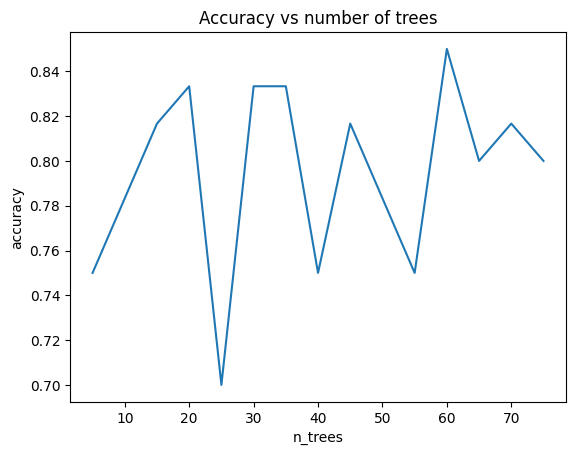

In [15]:

file = open('optimise_n_trees.csv', 'w') #open a file to store the results
file.write('n_trees,accuracy,time\n') 
max_accuracy = 0
optimal_n_trees = 0
for i in range(5, 80, 5):
    a,t = run_model()
    if a > max_accuracy: #store the optimal number of trees and the maximum accuracy
        max_accuracy = a
        optimal_n_trees = i
    file.write(str(i) + ',' + str(a) + ',' + str(t) + '\n')
file.close()
print("Optimal n_trees:", optimal_n_trees)
print("Max accuracy:", max_accuracy)


df = pd.read_csv('optimise_n_trees.csv') #read the file with the results
plt.plot(df['n_trees'], df['accuracy']) #plot the accuracy vs the number of trees
plt.xlabel('n_trees')
plt.ylabel('accuracy')
plt.title('Accuracy vs number of trees') 

Finding optimal max_depth of the tree

Time taken: 6.333700895309448
Accuracy on test data: 0.7166666666666667
Classification report:
              precision    recall  f1-score   support

           1       0.50      1.00      0.67         3
           2       0.50      0.33      0.40         3
           3       0.67      0.67      0.67         3
           4       0.67      0.67      0.67         3
           5       0.75      1.00      0.86         3
           6       1.00      0.33      0.50         3
           7       0.00      0.00      0.00         3
           8       0.60      1.00      0.75         3
           9       1.00      0.67      0.80         3
          10       0.67      0.67      0.67         3
          11       0.75      1.00      0.86         3
          12       1.00      0.67      0.80         3
          13       0.67      0.67      0.67         3
          14       1.00      1.00      1.00         3
          15       1.00      1.00      1.00         3
          16       0.75      1.00      0

/Users/ameliemajor/Library/Python/3.10/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ameliemajor/Library/Python/3.10/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ameliemajor/Library/Python/3.10/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

Time taken: 6.515758991241455
Accuracy on test data: 0.8833333333333333
Classification report:
              precision    recall  f1-score   support

           1       0.75      1.00      0.86         3
           2       1.00      0.33      0.50         3
           3       1.00      0.67      0.80         3
           4       0.75      1.00      0.86         3
           5       1.00      1.00      1.00         3
           6       0.75      1.00      0.86         3
           7       1.00      1.00      1.00         3
           8       0.75      1.00      0.86         3
           9       1.00      0.67      0.80         3
          10       1.00      1.00      1.00         3
          11       0.75      1.00      0.86         3
          12       0.75      1.00      0.86         3
          13       1.00      0.67      0.80         3
          14       1.00      1.00      1.00         3
          15       1.00      1.00      1.00         3
          16       1.00      1.00      1

/Users/ameliemajor/Library/Python/3.10/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ameliemajor/Library/Python/3.10/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ameliemajor/Library/Python/3.10/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

Time taken: 6.2987377643585205
Accuracy on test data: 0.85
Classification report:
              precision    recall  f1-score   support

           1       0.75      1.00      0.86         3
           2       0.67      0.67      0.67         3
           3       0.67      0.67      0.67         3
           4       0.60      1.00      0.75         3
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         3
           7       1.00      0.67      0.80         3
           8       0.50      1.00      0.67         3
           9       1.00      1.00      1.00         3
          10       1.00      1.00      1.00         3
          11       0.67      0.67      0.67         3
          12       1.00      1.00      1.00         3
          13       1.00      0.67      0.80         3
          14       1.00      0.67      0.80         3
          15       1.00      0.67      0.80         3
          16       1.00      1.00      1.00         3

/Users/ameliemajor/Library/Python/3.10/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ameliemajor/Library/Python/3.10/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ameliemajor/Library/Python/3.10/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

Time taken: 6.323207855224609
Accuracy on test data: 0.7666666666666667
Classification report:
              precision    recall  f1-score   support

           1       0.60      1.00      0.75         3
           2       0.50      0.67      0.57         3
           3       1.00      0.67      0.80         3
           4       1.00      1.00      1.00         3
           5       0.75      1.00      0.86         3
           6       1.00      0.33      0.50         3
           7       0.00      0.00      0.00         3
           8       0.60      1.00      0.75         3
           9       1.00      1.00      1.00         3
          10       0.75      1.00      0.86         3
          11       0.40      0.67      0.50         3
          12       1.00      0.33      0.50         3
          13       1.00      0.33      0.50         3
          14       1.00      1.00      1.00         3
          15       1.00      1.00      1.00         3
          16       1.00      1.00      1

/Users/ameliemajor/Library/Python/3.10/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ameliemajor/Library/Python/3.10/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ameliemajor/Library/Python/3.10/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

Time taken: 6.385635137557983
Accuracy on test data: 0.8166666666666667
Classification report:
              precision    recall  f1-score   support

           1       0.75      1.00      0.86         3
           2       1.00      0.33      0.50         3
           3       0.67      0.67      0.67         3
           4       1.00      0.67      0.80         3
           5       0.75      1.00      0.86         3
           6       1.00      0.67      0.80         3
           7       1.00      0.67      0.80         3
           8       0.60      1.00      0.75         3
           9       1.00      1.00      1.00         3
          10       0.75      1.00      0.86         3
          11       0.75      1.00      0.86         3
          12       1.00      0.67      0.80         3
          13       0.67      0.67      0.67         3
          14       1.00      0.67      0.80         3
          15       1.00      1.00      1.00         3
          16       1.00      1.00      1

/Users/ameliemajor/Library/Python/3.10/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ameliemajor/Library/Python/3.10/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ameliemajor/Library/Python/3.10/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

Time taken: 6.194612979888916
Accuracy on test data: 0.8166666666666667
Classification report:
              precision    recall  f1-score   support

           1       0.40      0.67      0.50         3
           2       0.67      0.67      0.67         3
           3       1.00      0.67      0.80         3
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         3
           6       0.75      1.00      0.86         3
           7       0.00      0.00      0.00         3
           8       0.60      1.00      0.75         3
           9       1.00      0.67      0.80         3
          10       1.00      1.00      1.00         3
          11       0.60      1.00      0.75         3
          12       0.67      0.67      0.67         3
          13       1.00      0.67      0.80         3
          14       1.00      1.00      1.00         3
          15       1.00      1.00      1.00         3
          16       0.75      1.00      0

/Users/ameliemajor/Library/Python/3.10/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ameliemajor/Library/Python/3.10/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ameliemajor/Library/Python/3.10/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

Time taken: 6.240024089813232
Accuracy on test data: 0.8666666666666667
Classification report:
              precision    recall  f1-score   support

           1       0.75      1.00      0.86         3
           2       1.00      0.67      0.80         3
           3       1.00      0.67      0.80         3
           4       1.00      1.00      1.00         3
           5       0.75      1.00      0.86         3
           6       1.00      0.67      0.80         3
           7       1.00      0.33      0.50         3
           8       0.75      1.00      0.86         3
           9       1.00      1.00      1.00         3
          10       0.75      1.00      0.86         3
          11       0.67      0.67      0.67         3
          12       0.75      1.00      0.86         3
          13       1.00      1.00      1.00         3
          14       1.00      0.67      0.80         3
          15       1.00      1.00      1.00         3
          16       1.00      1.00      1

/Users/ameliemajor/Library/Python/3.10/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ameliemajor/Library/Python/3.10/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ameliemajor/Library/Python/3.10/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

Time taken: 6.2963547706604
Accuracy on test data: 0.85
Classification report:
              precision    recall  f1-score   support

           1       1.00      0.67      0.80         3
           2       0.67      0.67      0.67         3
           3       0.75      1.00      0.86         3
           4       0.75      1.00      0.86         3
           5       1.00      0.67      0.80         3
           6       0.60      1.00      0.75         3
           7       0.67      0.67      0.67         3
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         3
          10       1.00      1.00      1.00         3
          11       0.75      1.00      0.86         3
          12       0.67      0.67      0.67         3
          13       1.00      0.67      0.80         3
          14       1.00      0.67      0.80         3
          15       1.00      0.67      0.80         3
          16       1.00      1.00      1.00         3
  

/Users/ameliemajor/Library/Python/3.10/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ameliemajor/Library/Python/3.10/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ameliemajor/Library/Python/3.10/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

Time taken: 6.353458881378174
Accuracy on test data: 0.8666666666666667
Classification report:
              precision    recall  f1-score   support

           1       0.75      1.00      0.86         3
           2       0.67      0.67      0.67         3
           3       0.67      0.67      0.67         3
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         3
           7       1.00      0.33      0.50         3
           8       0.60      1.00      0.75         3
           9       1.00      1.00      1.00         3
          10       1.00      1.00      1.00         3
          11       0.75      1.00      0.86         3
          12       0.60      1.00      0.75         3
          13       1.00      0.67      0.80         3
          14       1.00      0.33      0.50         3
          15       1.00      1.00      1.00         3
          16       1.00      1.00      1

Text(0.5, 1.0, 'Accuracy vs maximum tree depth')

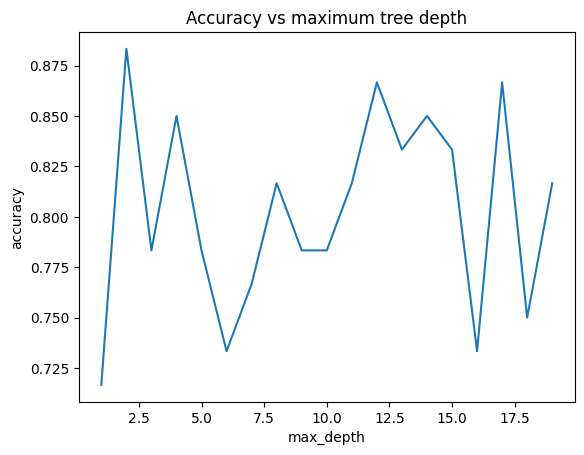

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import time
file = open('optimise_max_depth.csv', 'w') #open a file to store the results
file.write('max_depth,accuracy,time\n')
max_accuracy = 0
optimal_max_depth = 0

for i in range(1, 20): #loop through the maximum depth of the tree
    a,t = run_model()
    if a > max_accuracy: #store the optimal maximum depth and the maximum accuracy
        max_accuracy = a
        optimal_max_depth = i
    file.write(str(i) + ',' + str(a) + ',' + str(t) + '\n')

print("Optimal max_depth:", optimal_max_depth) #print the optimal maximum depth and the maximum accuracy
print("Max accuracy:", max_accuracy)
file.close()

df = pd.read_csv('optimise_max_depth.csv') #read the file with the results
plt.plot(df['max_depth'], df['accuracy'])
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.title('Accuracy vs maximum tree depth')

Finding optimal minimum sample splits

Time taken: 6.179089069366455
Accuracy on test data: 0.7833333333333333
Classification report:
              precision    recall  f1-score   support

           1       0.33      0.67      0.44         3
           2       0.67      0.67      0.67         3
           3       0.67      0.67      0.67         3
           4       0.75      1.00      0.86         3
           5       1.00      1.00      1.00         3
           6       0.60      1.00      0.75         3
           7       0.00      0.00      0.00         3
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         3
          10       1.00      1.00      1.00         3
          11       0.75      1.00      0.86         3
          12       1.00      0.67      0.80         3
          13       1.00      0.33      0.50         3
          14       0.00      0.00      0.00         3
          15       1.00      1.00      1.00         3
          16       0.75      1.00      0

/Users/ameliemajor/Library/Python/3.10/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ameliemajor/Library/Python/3.10/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ameliemajor/Library/Python/3.10/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

Time taken: 6.1699059009552
Accuracy on test data: 0.7833333333333333
Classification report:
              precision    recall  f1-score   support

           1       0.50      0.33      0.40         3
           2       0.67      0.67      0.67         3
           3       1.00      0.67      0.80         3
           4       0.75      1.00      0.86         3
           5       1.00      1.00      1.00         3
           6       0.50      0.67      0.57         3
           7       0.00      0.00      0.00         3
           8       0.67      0.67      0.67         3
           9       1.00      0.67      0.80         3
          10       1.00      1.00      1.00         3
          11       0.60      1.00      0.75         3
          12       0.60      1.00      0.75         3
          13       0.75      1.00      0.86         3
          14       1.00      0.33      0.50         3
          15       1.00      1.00      1.00         3
          16       1.00      1.00      1.0

/Users/ameliemajor/Library/Python/3.10/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ameliemajor/Library/Python/3.10/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ameliemajor/Library/Python/3.10/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

Time taken: 6.219644784927368
Accuracy on test data: 0.8
Classification report:
              precision    recall  f1-score   support

           1       0.50      1.00      0.67         3
           2       0.67      0.67      0.67         3
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         3
           6       0.50      0.67      0.57         3
           7       0.00      0.00      0.00         3
           8       1.00      1.00      1.00         3
           9       1.00      0.67      0.80         3
          10       0.60      1.00      0.75         3
          11       0.50      1.00      0.67         3
          12       1.00      0.67      0.80         3
          13       1.00      0.33      0.50         3
          14       1.00      0.67      0.80         3
          15       1.00      1.00      1.00         3
          16       1.00      1.00      1.00         3
 

/Users/ameliemajor/Library/Python/3.10/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ameliemajor/Library/Python/3.10/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ameliemajor/Library/Python/3.10/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

Time taken: 6.321026086807251
Accuracy on test data: 0.85
Classification report:
              precision    recall  f1-score   support

           1       1.00      0.67      0.80         3
           2       0.67      0.67      0.67         3
           3       0.67      0.67      0.67         3
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         3
           7       1.00      0.33      0.50         3
           8       0.60      1.00      0.75         3
           9       1.00      1.00      1.00         3
          10       1.00      1.00      1.00         3
          11       0.75      1.00      0.86         3
          12       0.50      0.33      0.40         3
          13       0.75      1.00      0.86         3
          14       1.00      0.67      0.80         3
          15       1.00      1.00      1.00         3
          16       1.00      1.00      1.00         3


/Users/ameliemajor/Library/Python/3.10/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ameliemajor/Library/Python/3.10/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ameliemajor/Library/Python/3.10/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

Time taken: 6.264297008514404
Accuracy on test data: 0.8333333333333334
Classification report:
              precision    recall  f1-score   support

           1       0.60      1.00      0.75         3
           2       1.00      0.67      0.80         3
           3       0.67      0.67      0.67         3
           4       1.00      1.00      1.00         3
           5       0.75      1.00      0.86         3
           6       0.50      0.67      0.57         3
           7       1.00      0.67      0.80         3
           8       1.00      0.67      0.80         3
           9       1.00      1.00      1.00         3
          10       1.00      1.00      1.00         3
          11       0.75      1.00      0.86         3
          12       0.75      1.00      0.86         3
          13       1.00      1.00      1.00         3
          14       1.00      0.33      0.50         3
          15       1.00      0.67      0.80         3
          16       0.75      1.00      0

/Users/ameliemajor/Library/Python/3.10/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ameliemajor/Library/Python/3.10/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ameliemajor/Library/Python/3.10/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

Time taken: 6.3432300090789795
Accuracy on test data: 0.7833333333333333
Classification report:
              precision    recall  f1-score   support

           1       0.50      0.67      0.57         3
           2       1.00      0.67      0.80         3
           3       0.50      0.33      0.40         3
           4       1.00      1.00      1.00         3
           5       0.75      1.00      0.86         3
           6       1.00      0.33      0.50         3
           7       1.00      0.67      0.80         3
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         3
          10       1.00      1.00      1.00         3
          11       0.50      1.00      0.67         3
          12       0.75      1.00      0.86         3
          13       1.00      0.67      0.80         3
          14       0.67      0.67      0.67         3
          15       0.67      0.67      0.67         3
          16       1.00      1.00      

/Users/ameliemajor/Library/Python/3.10/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ameliemajor/Library/Python/3.10/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ameliemajor/Library/Python/3.10/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

Time taken: 6.508530139923096
Accuracy on test data: 0.85
Classification report:
              precision    recall  f1-score   support

           1       0.60      1.00      0.75         3
           2       1.00      0.67      0.80         3
           3       1.00      0.67      0.80         3
           4       0.50      1.00      0.67         3
           5       1.00      1.00      1.00         3
           6       0.75      1.00      0.86         3
           7       1.00      0.33      0.50         3
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         3
          10       1.00      1.00      1.00         3
          11       0.75      1.00      0.86         3
          12       1.00      0.67      0.80         3
          13       1.00      0.67      0.80         3
          14       1.00      0.33      0.50         3
          15       1.00      1.00      1.00         3
          16       1.00      1.00      1.00         3


Text(0.5, 1.0, 'accuracy vs min_samples_split')

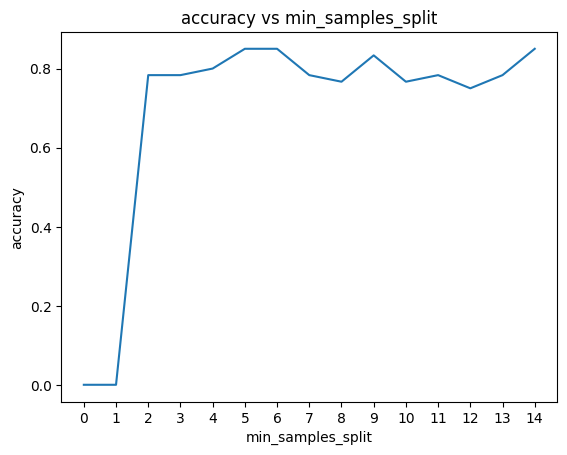

In [17]:

import matplotlib.pyplot as plt
import pandas as pd 

file = open('optimise_min_samples_split.csv', 'w') #open a file to store the results
file.write('min_depth,accuracy,time,\n')
file.write('0,0,0\n') # setting the minimum samples split to 0 will cause the model to overfit
file.write('1,0,0\n') # setting the minimum samples split to 1 will cause the model to overfit
max_accuracy = 0
optimal_min_samples_split = 0

for i in range(2, 15):
    a,t = run_model()
    if a > max_accuracy:
        max_accuracy = a
        optimal_min_samples_split = i
    file.write(str(i) + ',' + str(a) + ',' + str(t) + '\n')

print("Optimal min_samples_split:", optimal_min_samples_split) #print the optimal minimum samples split and the maximum accuracy
print("Max accuracy:", max_accuracy)   
file.close()

df = pd.read_csv('optimise_min_samples_split.csv')
plt.plot(df.index, df['accuracy'])
plt.xticks(df.index)
plt.xlabel('min_samples_split')
plt.ylabel('accuracy')
plt.title('accuracy vs min_samples_split')


Evaluate the model with the optimal hyperparameters

In [18]:
run_model(n_trees=optimal_n_trees, max_depth=optimal_max_depth, min_samples_split=optimal_min_samples_split)

Time taken: 10.401632070541382
Accuracy on test data: 0.48333333333333334
Classification report:
              precision    recall  f1-score   support

           1       0.50      0.33      0.40         3
           2       0.00      0.00      0.00         3
           3       0.33      1.00      0.50         3
           4       0.27      1.00      0.43         3
           5       0.60      1.00      0.75         3
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         3
           8       0.50      0.67      0.57         3
           9       1.00      0.67      0.80         3
          10       1.00      0.67      0.80         3
          11       0.00      0.00      0.00         3
          12       0.33      0.33      0.33         3
          13       0.00      0.00      0.00         3
          14       0.00      0.00      0.00         3
          15       0.50      0.67      0.57         3
          16       1.00      1.00     

/Users/ameliemajor/Library/Python/3.10/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ameliemajor/Library/Python/3.10/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ameliemajor/Library/Python/3.10/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

(0.48333333333333334, 10.401632070541382)

Precision: 0.7683
Recall: 0.7667
F1-Score: 0.7462


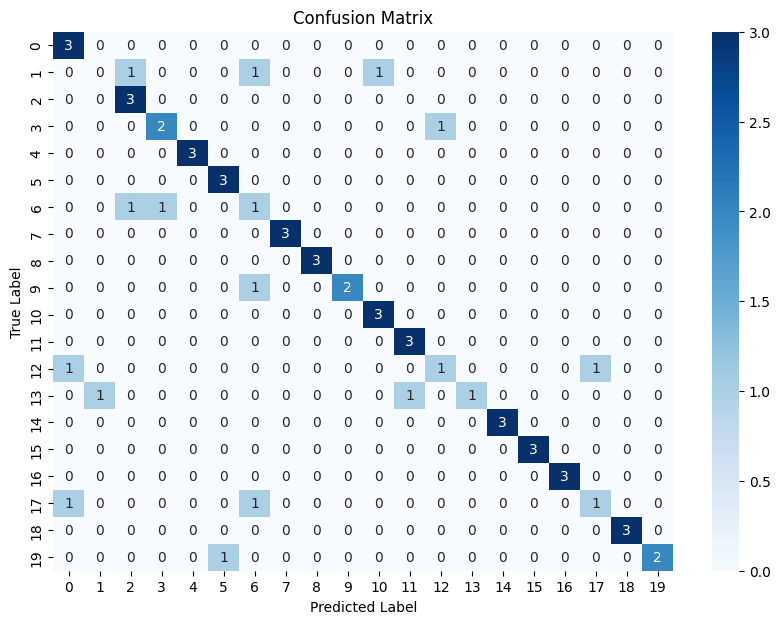

In [19]:
mmbra.diverse_evaluation_metrics_example(test_label_np, test_predictions)
mmbra.evaluation_visualization_example(test_label_np, test_predictions)

**Introducing new splitting**

In this section, variations in the trainig/testing split are used to conclude which is the optimal number of training samples

In [20]:
load_data() #use the laod data function to load the data again before being split into training and test data

In [ ]:
file = open('different_splits.csv', 'w') #open a file to store the results
file.write('no_of_training_values,accuracy,time\n') #write the header of the file
for i in range(2, 10): #loop through the number of training values
    train_features_multiple, train_label_np, test_features_multiple, test_label_np = partition_data(i)
    lda = LinearDiscriminantAnalysis()
    train_features_multiple = lda.fit_transform(train_features_multiple, train_label_np)
    test_features_multiple = lda.transform(test_features_multiple)
    a,t = run_model(n_trees=optimal_n_trees, max_depth=optimal_max_depth, min_samples_split=optimal_min_samples_split)
    file.write(str(i) + "," + str(a) + "," + str(t) + '\n')
file.close()

Time taken: 2.6246137619018555
Accuracy on test data: 0.10625
Classification report:
              precision    recall  f1-score   support

           1       0.17      0.12      0.14         8
           2       0.00      0.00      0.00         8
           3       0.09      0.38      0.14         8
           4       0.17      0.12      0.14         8
           5       0.00      0.00      0.00         8
           6       1.00      0.12      0.22         8
           7       0.00      0.00      0.00         8
           8       0.00      0.00      0.00         8
           9       0.05      0.12      0.07         8
          10       0.05      0.12      0.07         8
          11       0.00      0.00      0.00         8
          12       0.13      0.25      0.17         8
          13       0.00      0.00      0.00         8
          14       0.00      0.00      0.00         8
          15       0.00      0.00      0.00         8
          16       0.00      0.00      0.00       

/Users/ameliemajor/Library/Python/3.10/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ameliemajor/Library/Python/3.10/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ameliemajor/Library/Python/3.10/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

Time taken: 4.164453744888306
Accuracy on test data: 0.17857142857142858
Classification report:
              precision    recall  f1-score   support

           1       0.29      0.57      0.38         7
           2       0.00      0.00      0.00         7
           3       0.07      0.14      0.10         7
           4       0.00      0.00      0.00         7
           5       0.23      0.71      0.34         7
           6       0.00      0.00      0.00         7
           7       0.09      0.29      0.14         7
           8       0.11      0.14      0.12         7
           9       0.29      0.86      0.43         7
          10       0.33      0.14      0.20         7
          11       0.00      0.00      0.00         7
          12       0.00      0.00      0.00         7
          13       0.00      0.00      0.00         7
          14       0.00      0.00      0.00         7
          15       0.29      0.29      0.29         7
          16       0.25      0.14      

/Users/ameliemajor/Library/Python/3.10/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ameliemajor/Library/Python/3.10/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ameliemajor/Library/Python/3.10/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

KeyboardInterrupt: 

Text(0.5, 1.0, 'accuracy vs train-test split')

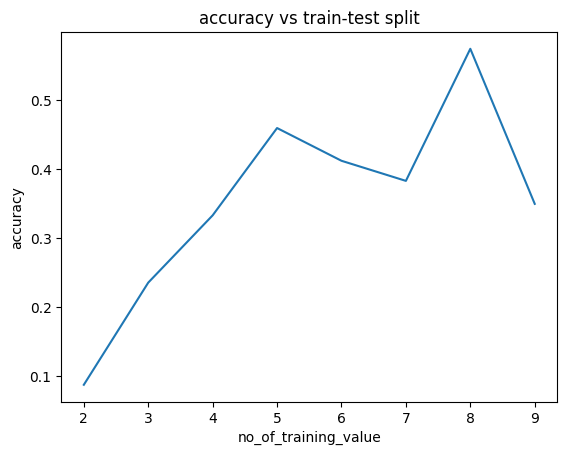

In [25]:
df = pd.read_csv('different_splits.csv') #read the file with the results
plt.plot(df['no_of_training_values'], df['accuracy']) #plot the accuracy vs the number of training values
plt.xlabel('no_of_training_value')
plt.ylabel('accuracy') 
plt.title('accuracy vs train-test split')   
